## Exercici
Resumeix gràficament el data set DelayedFlights.csv *[Airlines Delay: Airline on-time statistics and delay causes](https://www.kaggle.com/giovamata/airlinedelaycauses)*

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joypy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#importem el dataset
pd.options.display.max_columns = None

datasets_path = r"D:\Oscar\FORMACIO\DIGITAL\DATA SCIENCE with Python\Datasets" + os.sep
file = datasets_path + "DelayedFlights.csv"
dataset = pd.read_csv(file, sep=',', encoding='utf8', index_col=0)

rename ={'UniqueCarrier':'AEROLÍNIA', 'ArrDelay':'RETARD ARRIBADA',
         'DepDelay':'RETARD SORTIDA', 'AirTime':'DURACIÓ DEL VOL'}

#generem un nou dataframe amb les dades que utilitzarem per la pràctica
dataset.rename(columns=rename, inplace=True)
cols = ['AEROLÍNIA', 'RETARD ARRIBADA', 'RETARD SORTIDA', 'DURACIÓ DEL VOL', "Year", "Month", "DayofMonth"]
df = dataset[cols].copy()
del dataset

#eliminem els nulls
df.dropna(subset=["RETARD ARRIBADA"], how='any', inplace=True)

#convertim a float32 les columnes numèriques
cols.remove('AEROLÍNIA')
dtype = ["int32"] * len(cols)
dic = dict(zip(cols, dtype))
df = df.astype(dic)

#importem l'arxiu d'aerolínies com una series
file = datasets_path + "DelayedFlights-carriers.csv"
ap_s = pd.read_csv(file, sep=',', encoding='utf8', index_col=0, squeeze=True)
ap_s.sample(3)

#subsituïm la columna del codi pel seu nom a partir de la taula
#creem la nova columna mapejant la series
df["AEROLÍNIA"] = df["AEROLÍNIA"].map(ap_s)
del ap_s

#treiem l'explicació entre parèntesi d'una aerolínia que ens allarga molt el titol
import re
df["AEROLÍNIA"] = df["AEROLÍNIA"].apply(lambda x: re.sub(r' +\(.*\)', '', x))

df.sample(3)

,AEROLÍNIA,RETARD ARRIBADA,RETARD SORTIDA,DURACIÓ DEL VOL,Year,Month,DayofMonth
4142288,American Airlines Inc.,15,22,167,2008,7,7
296957,Southwest Airlines Co.,88,96,256,2008,1,1
3676433,Southwest Airlines Co.,23,38,122,2008,7,24


In [5]:
#treiem dates màxima i mínima del dataframe per agregar-li una informació al títol
des_s = df.sort_values(by=["Year", "Month", "DayofMonth"]).iloc[0]
fins_s = df.sort_values(by=["Year", "Month", "DayofMonth"]).iloc[-1]

b = "/"
des = str(des_s.DayofMonth) + b + str(des_s.Month) + b + str(des_s.Year)
fins = str(fins_s.DayofMonth) + b + str(fins_s.Month) + b + str(fins_s.Year)
titol_info = " Dades des del {0} fins al {1}".format(des, fins)

### Visualització de Una variable categòrica (UniqueCarrier)

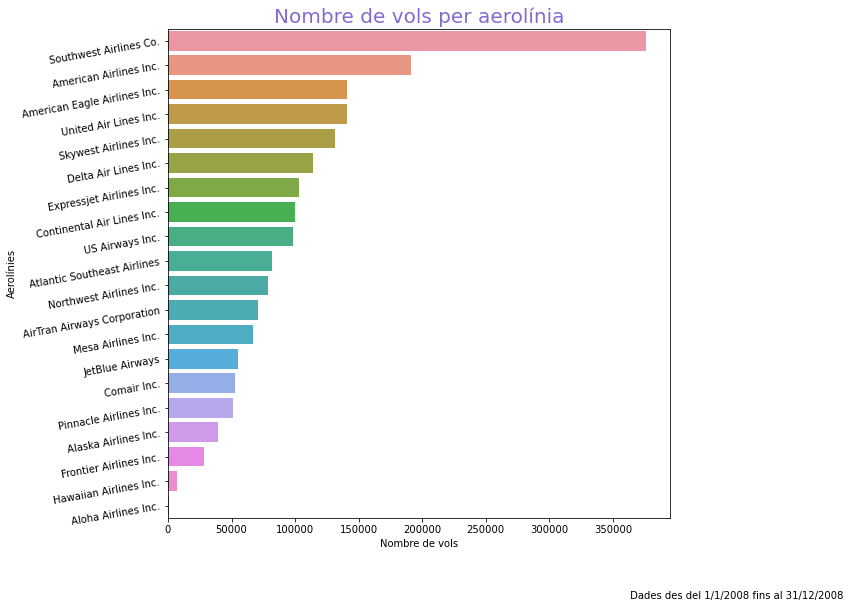

In [6]:
#visualitzem utilitzant seaborn el nombre de vols per aerolínia
titol = "Nombre de vols per aerolínia"
plt.figure(figsize =(9, 9))
axis = sns.countplot(y="AEROLÍNIA", data=df, order=df['AEROLÍNIA'].value_counts().index)
plt.yticks(rotation=10)
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
plt.ylabel('Aerolínies')
plt.xlabel('Nombre de vols')
desa_figura(plt, titol)
plt.show()

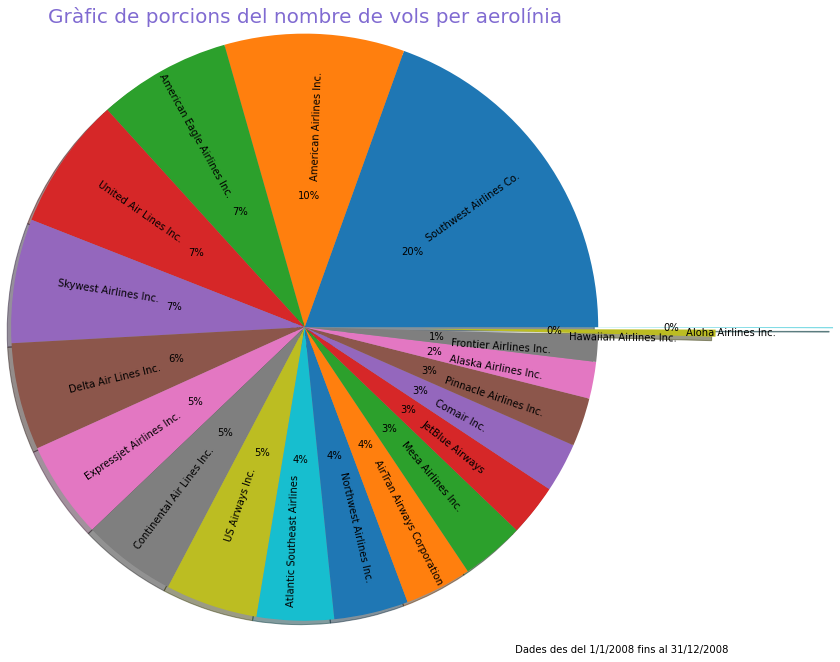

In [7]:
#el mateix però en gràfic circular
data = df['AEROLÍNIA'].value_counts()
titol = "Gràfic de porcions del nombre de vols per aerolínia"

#extreiem una proporció de les porcions de les dues aerolínies amb menys vols per visualitzar-ho sense solapament
myexplode = [0] * len(data.index)
myexplode[-2:] = [.6, 1.2]

plt.figure(figsize =(9, 9))
plt.pie(x=data.values, labels=data.index, autopct='%1.0f%%', startangle=0, explode=myexplode, shadow = True,
        pctdistance=.45, labeldistance=.5, rotatelabels=True, radius=1.5, normalize=True)

plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8, loc="center", pad=60)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
desa_figura(plt, titol)
plt.show()

### Visualització d'una variable numèrica (ArrDelay)

In [8]:
#funció per arrodonir al multiple de 10 més proper (cap amunt: direccio = "sup"; cap avall: direccio = "inf")
#la creem per establir els ticks dels eixos al múltiple de 10 més proper als quantils q1 i q2 establerts
def round10(x, direccio):
    if x % 10 == 0: return int(x)
    x = int(x)
    if x == 0: return 0
    last_digit = int(str(x)[-1])
    if x < 0:
        if direccio == "sup": return (x + last_digit)
        elif direccio == "inf": return (x - 10 + last_digit)
    elif x > 0:
        if direccio == "sup": return (x + 10 - last_digit)
        elif direccio == "inf": return (x - last_digit)
        
#creem una funció que donada una series i el porcentatge dels quantils ens retornarà un rang dels valors temporals
#de la series pasada per fer visualitzacions selectives dels rangs significatius (arrodonirem aquests valors a desenes)
def genera_rang_arrodonit(series, qmin, qmax):
    qmin /= 100
    qmax /= 100
    values = series.values
    vmin, vmax = np.quantile(values, qmin), np.quantile(values, qmax)
    vmin = round10(vmin, "inf")
    vmax = round10(vmax, "sup")
    return vmin, vmax

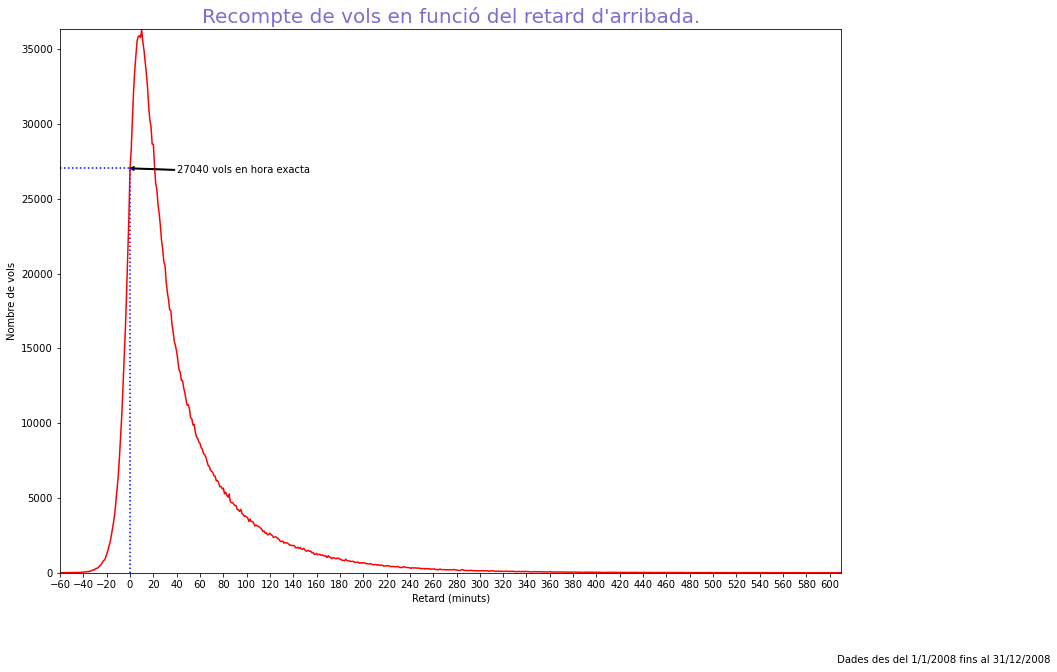

In [15]:
data = df["RETARD ARRIBADA"].value_counts()
titol = "Recompte de vols en funció del retard d'arribada."

#dibuixarem la gràfica entre els els quantils que van del 5 al 60% (arrodonits a desenes)
xmin, xmax = genera_rang_arrodonit(data.index, 1, 60)

plt.figure(figsize =(14, 10))
sns.lineplot(x=data.index, y=data.values, color="r")
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
plt.xlabel('Retard (minuts)')
plt.ylabel('Nombre de vols')

plt.vlines(x=0, ymin=0, ymax=data[0], colors="blue", linestyles="dotted")
plt.hlines(y=data[0], xmin=xmin, xmax=0, colors="blue", linestyles="dotted")
plt.annotate(text="{} vols en hora exacta".format(data[0]), xy=(0, data[0]), 
             xytext=(40 , data[0] + 225), 
             arrowprops=dict(facecolor='blue', headwidth=4, width=1, headlength=4), 
             horizontalalignment='left', verticalalignment='top')

plt.xlim(xmin, xmax)
plt.ylim(0, data.values.max()+50)
plt.xticks(np.arange(xmin, xmax, step=20))
desa_figura(plt, titol)
plt.show()

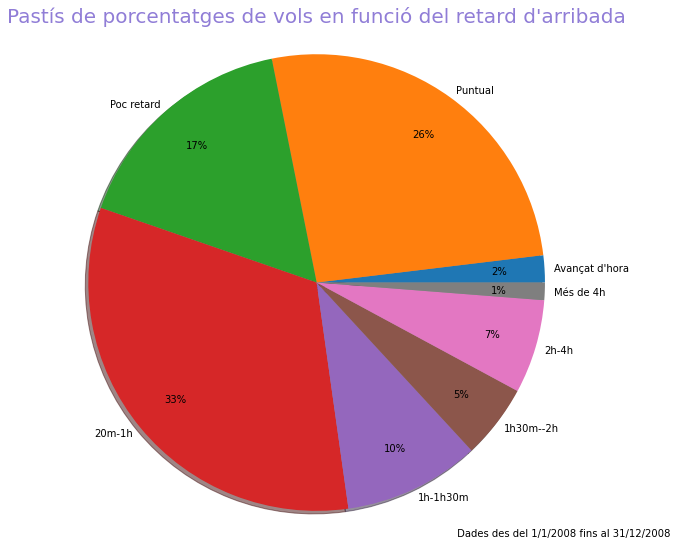

In [10]:
#podríem discretitzar aquesta variable fent intervals significatius per nosaltres dels temps de retard
#per visualitzar el grafic de porcions de retards. (El considerem enraderit quan arriba més tard de 10 min de l'hora prevista)
data = df['RETARD ARRIBADA'].values
titol = "Pastís de porcentatges de vols en funció del retard d'arribada"

def m(temps):
    hores = temps[0]
    minuts = temps[1]
    return hores*60 + minuts + 1

bins = [data.min(), -10, m([0,10]), m([0,20]), m([1,0]), m([1,30]), m([2,0]),
        m([4,0]), data.max()+1]

retard_lbl = ["Avançat d'hora", "Puntual", "Poc retard", "20m-1h", "1h-1h30m", 
              "1h30m--2h", "2h-4h", "Més de 4h"]

#amb la funció histogram de numpy podem veure els valors del conteig dels blocs categoritzats
histograma = np.histogram(data, bins=bins)
recompte = histograma[0]

plt.figure(figsize =(7, 7))
plt.pie(recompte, labels=retard_lbl, startangle=0, shadow = True, pctdistance=.8, labeldistance=1.04, 
        rotatelabels=False, radius=1.5, autopct='%1.0f%%')
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.7, loc="center", pad=70)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
desa_figura(plt, titol)
plt.show()

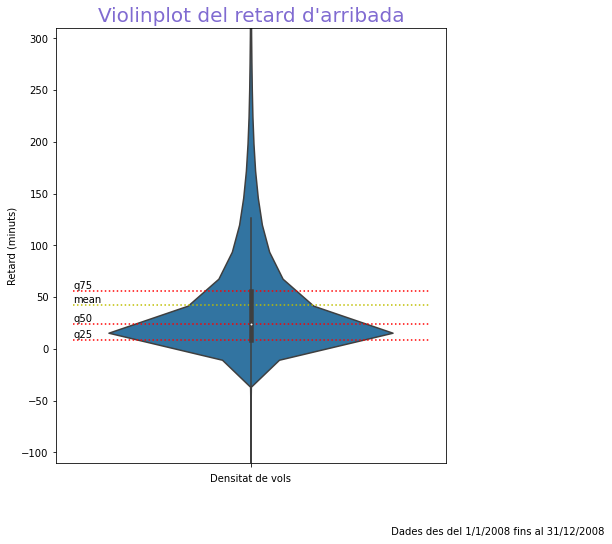

In [16]:
#Podem dibuixar el Violinplot de densitats de retards d'arribada
data = df['RETARD ARRIBADA']
titol = "Violinplot del retard d'arribada"
ymin, ymax = genera_rang_arrodonit(data, 0, 99.5)

plt.figure(figsize=(7, 8))
axes = sns.violinplot(y=data)
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
plt.ylabel('Retard (minuts)')
plt.xlabel('Densitat de vols')

#dibuixem els quantils q25, q50, q75 (vermells) i promig (groc)
quantils = list(np.quantile(data.values, [.25,.5,.75]))
quantils.append(data.values.mean())
colors = ["r", "r", "r", "y"]
plt.hlines(y=quantils, xmin=-.5, xmax=.5, colors=colors, linestyles="dotted")
text = ["q25", "q50", "q75", "mean"]
for i in range(len(text)):
    plt.annotate(text=text[i], xy=(-.5 , quantils[i]), horizontalalignment='left', verticalalignment='bottom')
    
plt.ylim(ymin, ymax)

desa_figura(plt, titol)
plt.show()

In [17]:
#podem comprobar que els valors s'ajusten als dels gràfics
round(df["RETARD ARRIBADA"].describe(),1)

count    1928371.0
mean          42.2
std           56.8
min         -109.0
25%            9.0
50%           24.0
75%           56.0
max         2461.0
Name: RETARD ARRIBADA, dtype: float64

### Visualització d'una variable numèrica i una categòrica (ArrDelay i UniqueCarrier)

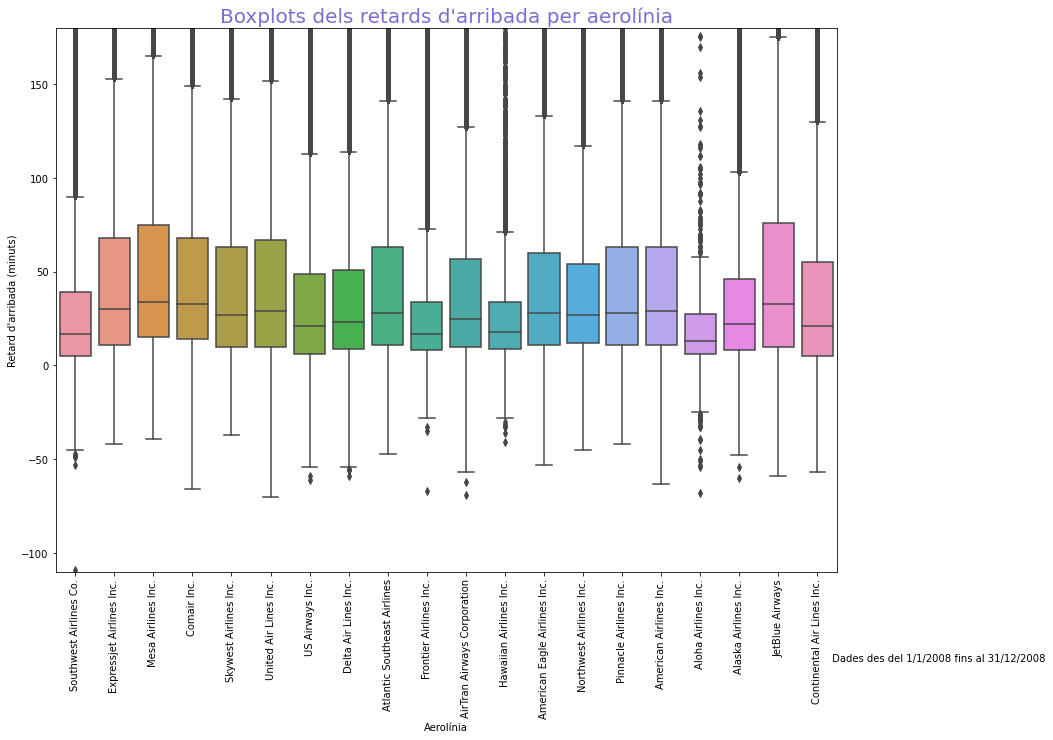

In [18]:
data = df[['AEROLÍNIA', 'RETARD ARRIBADA']]

titol = "Boxplots dels retards d'arribada per aerolínia"
#establim el rang de visualització entre els quantils que van del 0 al 97% (Arrodonint a desenes)
ymin, ymax = genera_rang_arrodonit(data["RETARD ARRIBADA"], 0, 97)

plt.figure(figsize =(14, 10))
sns.boxplot(x=data["AEROLÍNIA"], y=data["RETARD ARRIBADA"])
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
plt.xlabel("Aerolínia")
plt.ylabel("Retard d'arribada (minuts)")
plt.xticks(rotation='vertical')
plt.ylim(ymin, ymax)

desa_figura(plt, titol)
plt.show()

In [26]:
#podriem visualitzar els valors significatius dels quantils i promig
def q25(x):
    return np.quantile(x, .25)
def q50(x):
    return np.quantile(x, .5)
def q75(x):
    return np.quantile(x, .75)

data = df[['AEROLÍNIA', 'RETARD ARRIBADA']]
agr = {'RETARD ARRIBADA': [q25, q50, q75, "mean"]}
data = data.groupby("AEROLÍNIA", as_index=False).agg(agr).round(2)
data.columns = data.columns.droplevel(level=0)
data.rename(columns={"": "AEROLÍNIA"}, inplace=True)
data

,AEROLÍNIA,q25,q50,q75,mean
0,AirTran Airways Corporation,10,25,57.00,43.68
1,Alaska Airlines Inc.,8,22,46.00,36.06
2,Aloha Airlines Inc.,6,13,27.25,21.26
3,American Airlines Inc.,11,29,63.00,46.56
4,American Eagle Airlines Inc.,11,28,60.00,45.30
5,Atlantic Southeast Airlines,11,28,63.00,47.55
6,Comair Inc.,14,33,68.00,51.02
7,Continental Air Lines Inc.,5,21,55.00,40.57
8,Delta Air Lines Inc.,9,23,51.00,39.88
9,Expressjet Airlines Inc.,11,30,68.00,50.18


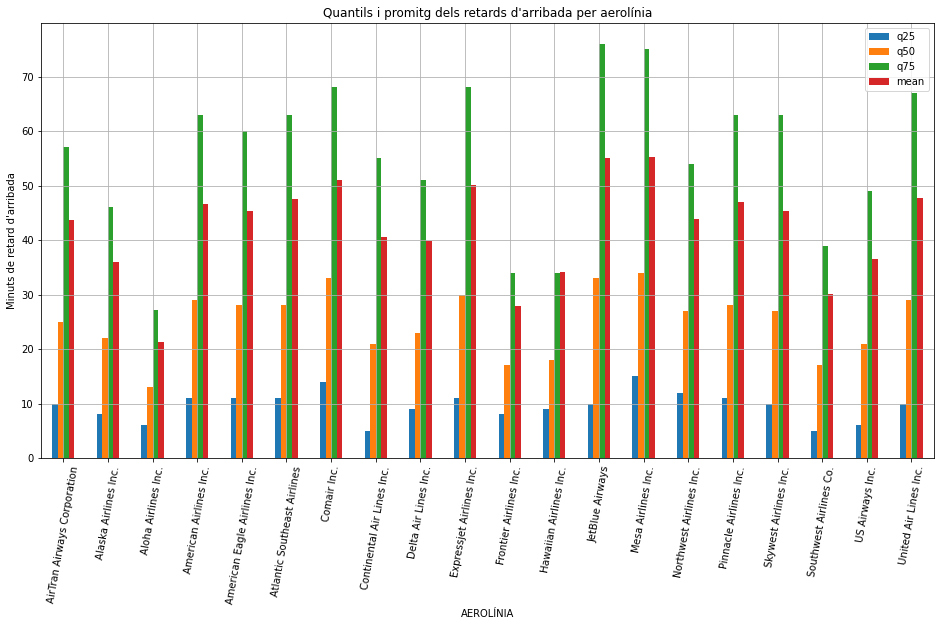

In [27]:
#inclús podriem dibuixar aquests valors
titol = "Quantils i promitg dels retards d'arribada per aerolínia"

p = data.plot(x="AEROLÍNIA", y=["q25", "q50", "q75", "mean"], kind="bar", figsize=(16, 8), 
              ylabel="Minuts de retard d'arribada", grid=True, rot=80, title=titol)
desa_figura(plt, titol)

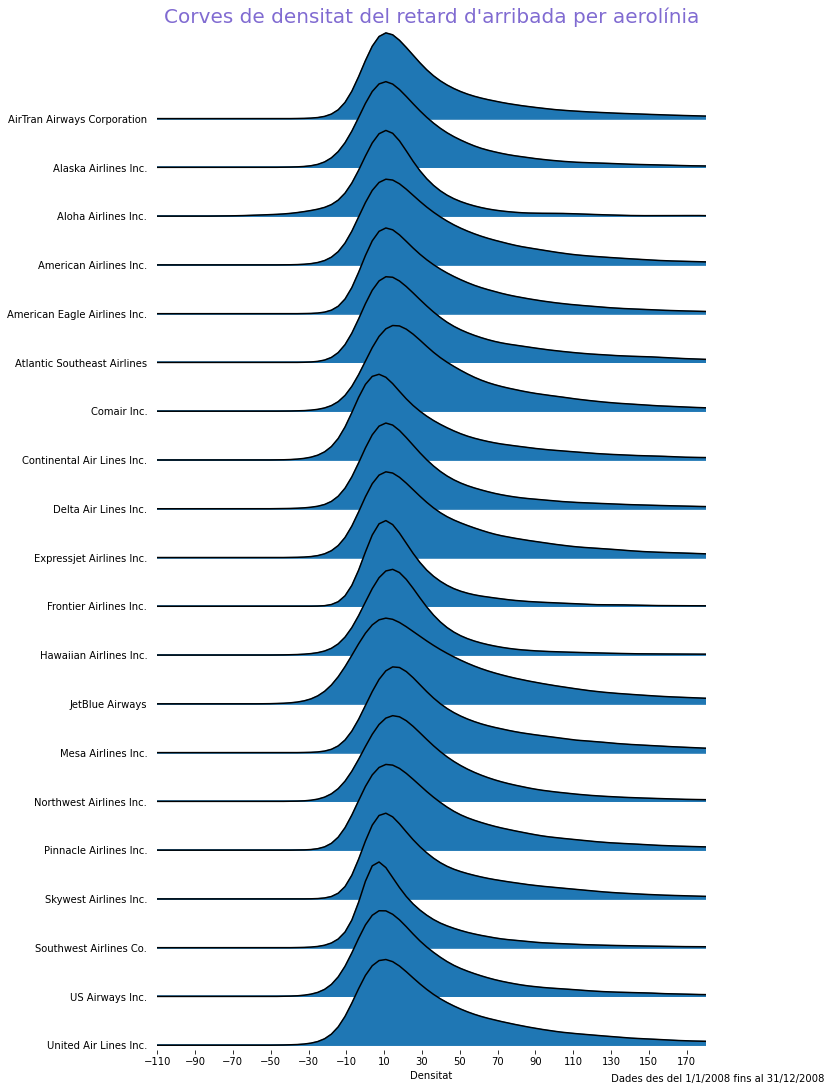

In [29]:
#Amb joypy podriem dibuixar una ridgeline amb la corva de densitat de retards d'arribada per cadascuna de les aerolínies
titol = "Corves de densitat del retard d'arribada per aerolínia"
data = df[['AEROLÍNIA', 'RETARD ARRIBADA']]

#establim el rang de visualització entre els quantils que van del 0 al 97%
xmin, xmax = genera_rang_arrodonit(data["RETARD ARRIBADA"], 0, 97)

#dibuixem
fig, axes = joypy.joyplot(data=data, column=['RETARD ARRIBADA'], by='AEROLÍNIA', figsize=(10, 15), ylim='own', title=titol)
plt.rc("font", size=12)
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
plt.xlabel("Temps de retard d'arribada (m)")
plt.xlabel("Densitat")

#Establim els limits de visualització  i els ticks al gràfic (cada aerolínia és un axes i l'eix x n'és un altre)
for i in range(len(df["AEROLÍNIA"].unique())+1):
    axes[i].set_xlim(xmin, xmax)
axes[-1].set_xticks(range(xmin, xmax, 20))

desa_figura(plt, titol)
plt.show()

### Visualització de dues variables numèriques (ArrDelay i DepDelay)

<Figure size 1008x720 with 0 Axes>

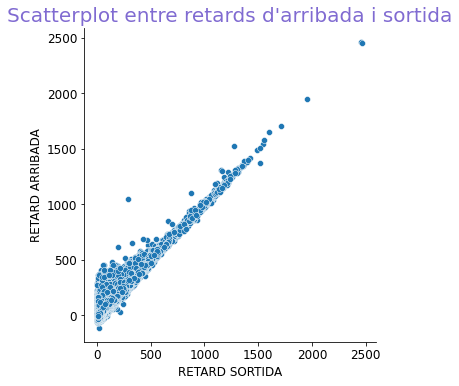

In [30]:
data = df[["RETARD SORTIDA", "RETARD ARRIBADA"]]
titol = "Scatterplot entre retards d'arribada i sortida"

#fem l'scatterplot entre les dues columnes
plt.figure(figsize =(14, 10))
axes = sns.relplot(data=data, x="RETARD SORTIDA", y="RETARD ARRIBADA", kind="scatter")
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.show()

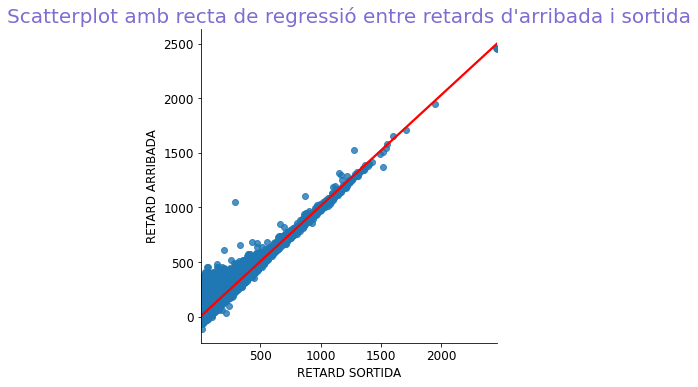

In [31]:
#podem observar que te una forta relació lineal entre les variables
#fem lineplot amb la linea de regressió entre les dues columnes
titol = "Scatterplot amb recta de regressió entre retards d'arribada i sortida"
sns.lmplot(data=data, x="RETARD SORTIDA", y="RETARD ARRIBADA", fit_reg=True, line_kws=dict(color="red"))
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.show()

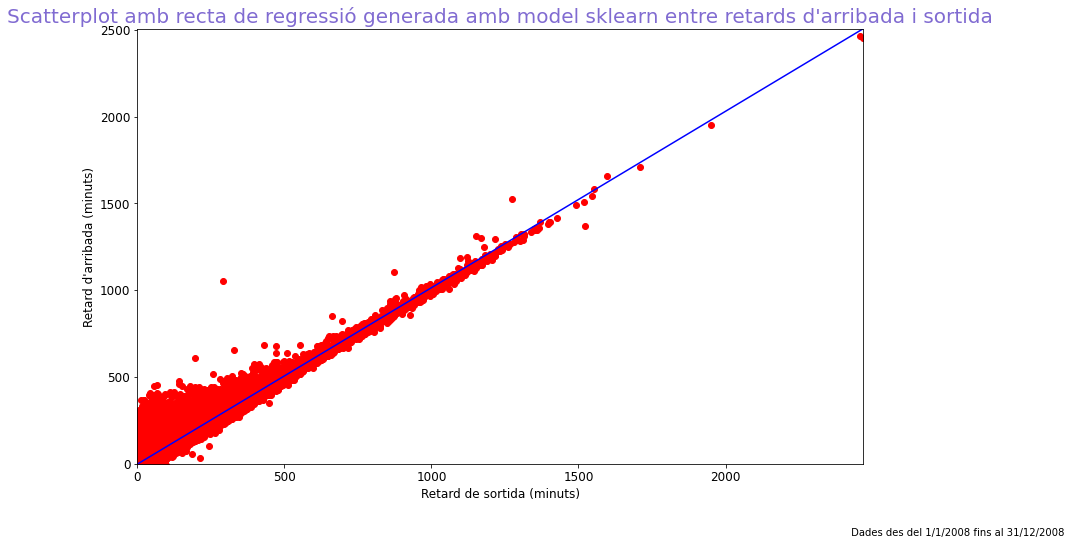

In [32]:
#com a curiositat podriem calcular nosaltres la recta de regressió lineal teient el model d'sklearn 
#i dibuixarla sobre un scatterplot per obtenir la mateixa sortida que hem obtingut amb seaborn.
from sklearn.linear_model import LinearRegression

rtd_sortida = df["RETARD SORTIDA"].values
rtd_arribada = df["RETARD ARRIBADA"].values
rtd_sortida = rtd_sortida.reshape(-1, 1)

model = LinearRegression()
model.fit(rtd_sortida, rtd_arribada)
beta_0_f = float(model.intercept_)
beta_1_f = float(model.coef_)

del rtd_sortida, rtd_arribada

titol = "Scatterplot amb recta de regressió generada amb model sklearn entre retards d'arribada i sortida"

def f(x):
    return beta_0_f + beta_1_f * x

x_samples_l = [0, int(df["RETARD SORTIDA"].max())]

plt.figure(figsize =(13, 8))
plt.plot(x_samples_l, [f(i) for i in x_samples_l], c="blue")
plt.scatter(df["RETARD SORTIDA"].values, df["RETARD ARRIBADA"].values, c="red")
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
plt.xlabel("Retard de sortida (minuts)")
plt.ylabel("Retard d'arribada (minuts)")
plt.xlim(0, df["RETARD SORTIDA"].max())
plt.ylim(0, f(df["RETARD SORTIDA"].max()))

desa_figura(plt, titol)
plt.show()

In [33]:
#podem calcular el coeficient de correlació on observem, com es veu a simple vista, que el retard d'arribada està fortament
#relacionat amb el de la sortida. Fent-la fácilment predible
np.corrcoef([df["RETARD SORTIDA"],df["RETARD ARRIBADA"]])[0,1]

0.9529266852026792

In [34]:
#també que la pendent de la recta es gairebé 1, i l'offset de -1 minut (molt petit), amb el que podríem concloure
#que el retard en les arribades gairebé amb la seva totalitat degut al de les sortides.
print("pendent:", beta_1_f, "/ offset:", beta_0_f)

pendent: 1.0158763368329562 / offset: -1.5759463952356754


### Visualització de tres variables (ArrDelay, DepDelay i UniqueCarrier)

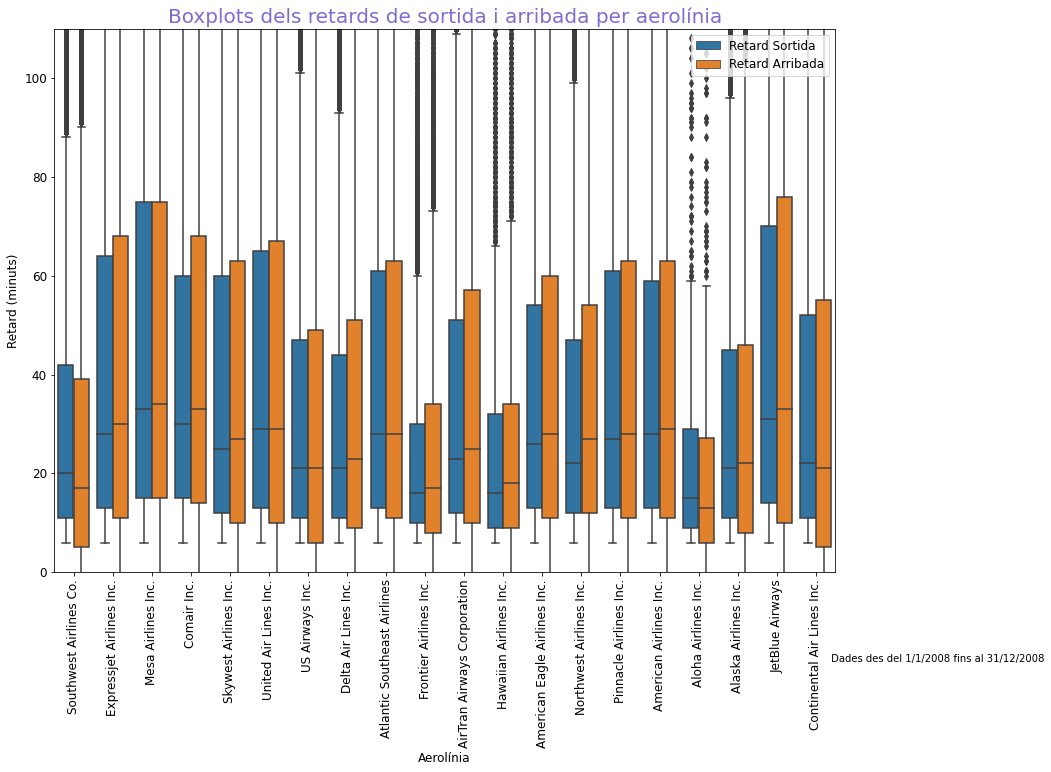

In [35]:
#dibuixem en boxplots els retards de sortida i arribada agrupats per aerolínia
r_sort_df = df[['AEROLÍNIA', 'RETARD SORTIDA']].copy()
r_sort_df.rename(columns={'RETARD SORTIDA': 'RETARD'}, inplace = True)
r_sort_df['TIPUS'] = "Retard Sortida"
r_arr_df = df[['AEROLÍNIA', 'RETARD ARRIBADA']].copy()
r_arr_df.rename(columns={'RETARD ARRIBADA': 'RETARD'}, inplace = True)
r_arr_df['TIPUS'] = "Retard Arribada"
data = pd.concat([r_sort_df, r_arr_df])
del r_sort_df, r_arr_df

titol = "Boxplots dels retards de sortida i arribada per aerolínia"
#establim els limits de visualització
ymin, ymax = genera_rang_arrodonit(data["RETARD"], 5, 90)

plt.figure(figsize =(14, 10))
sns.boxplot(x=data["AEROLÍNIA"], y=data["RETARD"], hue=data["TIPUS"], )
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
plt.xlabel("Aerolínia")
plt.ylabel("Retard (minuts)")
plt.xticks(rotation='vertical')
plt.legend(loc='upper right')
plt.ylim(ymin, ymax)

desa_figura(plt, titol)
plt.show()

In [36]:
#podriem visualitzar els valors significatius dels quantils i promig pels dos retards, per aerolínia
data = df[['AEROLÍNIA', 'RETARD SORTIDA', 'RETARD ARRIBADA']]
agr = {'RETARD ARRIBADA': [q25, q50, q75, "mean"], 'RETARD SORTIDA': [q25, q50, q75, "mean"],}
data = data.groupby("AEROLÍNIA", as_index=False).agg(agr).round(2)
data.set_index("AEROLÍNIA", inplace=True)
data

RETARD ARRIBADA                   RETARD SORTIDA  \
                                         q25 q50    q75   mean            q25   
AEROLÍNIA                                                                       
AirTran Airways Corporation               10  25  57.00  43.68             12   
Alaska Airlines Inc.                       8  22  46.00  36.06             11   
Aloha Airlines Inc.                        6  13  27.25  21.26              9   
American Airlines Inc.                    11  29  63.00  46.56             13   
American Eagle Airlines Inc.              11  28  60.00  45.30             13   
Atlantic Southeast Airlines               11  28  63.00  47.55             13   
Comair Inc.                               14  33  68.00  51.02             15   
Continental Air Lines Inc.                 5  21  55.00  40.57             11   
Delta Air Lines Inc.                       9  23  51.00  39.88             11   
Expressjet Airlines Inc.                  11  30  68.00  50.18             13   
Frontier Airlines Inc.                     8  17  34.00  27.94             10   
Hawaiian Airlines Inc.                     9  18  34.00  34.21              9   
JetBlue Airways                           10  33  76.00  55.09             14   
Mesa Airlines Inc.                        15  34  75.00  55.29             15   
Northwest Airlines Inc.                   12  27  54.00  43.91             12   
Pinnacle Airlines Inc.                    11  28  63.00  46.94             13   
Skywest Airlines Inc.                     10  27  63.00  45.37             12   
Southwest Airlines Co.                     5  17  39.00  30.09             11   
US Airways Inc.                            6  21  49.00  36.45             11   
United Air Lines Inc.                     10  29  67.00  47.78             13   

                                             
                             q50 q75   mean  
AEROLÍNIA                                    
AirTran Airways Corporation   23  51  42.49  
Alaska Airlines Inc.          21  45  37.98  
Aloha Airlines Inc.           15  29  26.02  
American Airlines Inc.        28  59  46.40  
American Eagle Airlines Inc.  26  54  43.60  
Atlantic Southeast Airlines   28  61  48.26  
Comair Inc.                   30  60  48.91  
Continental Air Lines Inc.    22  52  43.06  
Delta Air Lines Inc.          21  44  39.01  
Expressjet Airlines Inc.      28  64  49.96  
Frontier Airlines Inc.        16  30  27.67  
Hawaiian Airlines Inc.        16  32  33.06  
JetBlue Airways               31  70  54.94  
Mesa Airlines Inc.            33  75  55.35  
Northwest Airlines Inc.       22  47  41.26  
Pinnacle Airlines Inc.        27  61  47.35  
Skywest Airlines Inc.         25  60  44.70  
Southwest Airlines Co.        20  42  34.59  
US Airways Inc.               21  47  38.76  
United Air Lines Inc.         29  65  49.90

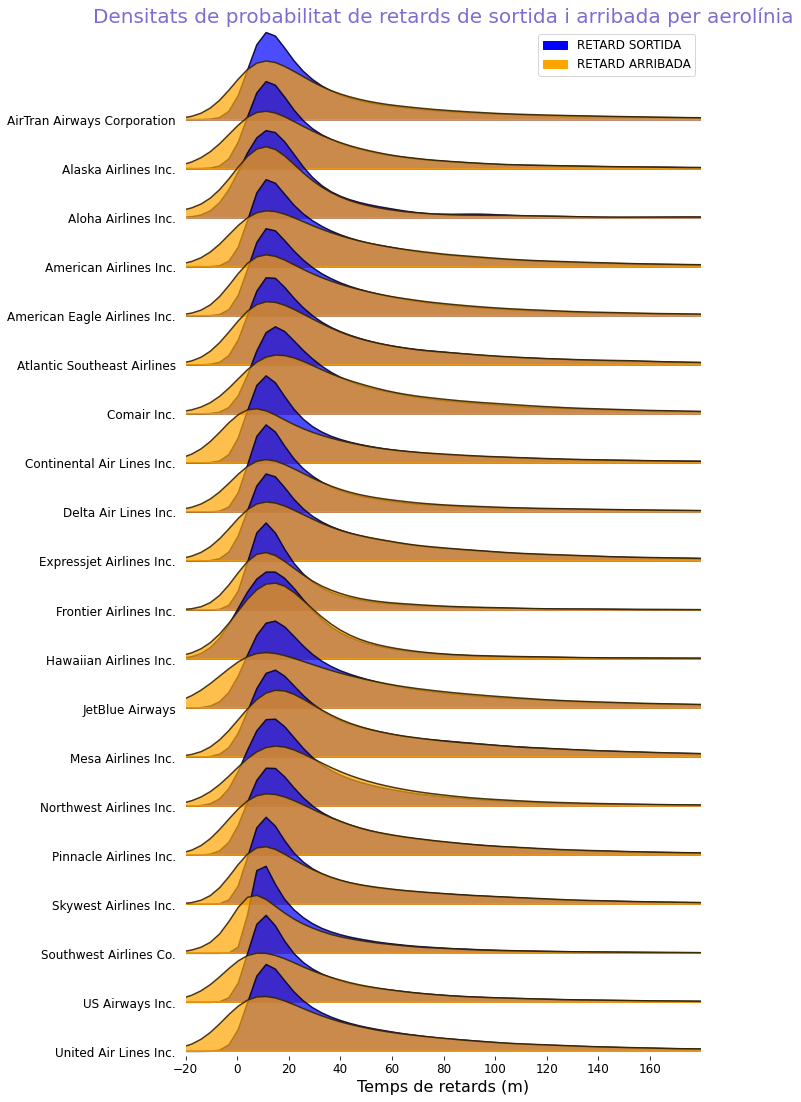

In [60]:
#podem dibuixar una ridgeline amb la corva de densitat de retards d'arribada i sortida per cadascuna de les aerolínies
data = df[['AEROLÍNIA', 'RETARD SORTIDA', 'RETARD ARRIBADA']]
titol = "Densitats de probabilitat de retards de sortida i arribada per aerolínia"
#calculem rang de l'eix x per visualitzar la part interesada (sense els outliers que queden fora de la nostra consideració)
#establim el rang de visualització entre els quantils que van de l'1 al 97%
qmin, qmax = 1, 97
xmin1, xmax1 = genera_rang_arrodonit(data["RETARD SORTIDA"], qmin, qmax)
xmin2, xmax2 = genera_rang_arrodonit(data["RETARD ARRIBADA"], qmin, qmax)
xmin, xmax = min([xmin1, xmin2]), max([xmax1, xmax2])

fig, axes = joypy.joyplot(data=data, column=['RETARD SORTIDA', 'RETARD ARRIBADA'], by="AEROLÍNIA", 
                          ylim='own', figsize=(10, 15), legend=True, color=['blue', 'orange'], alpha=0.7)
plt.rc("font", size=12)
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.xlabel("Temps de retards (m)",  fontsize=16)

#Establim els limits de visualització  i els ticks al gràfic (cada aerolínia és un axes i l'eix x n'és un altre)
for i in range(len(df["AEROLÍNIA"].unique())+1):
    axes[i].set_xlim(xmin, xmax)
axes[-1].set_xticks(range(xmin, xmax, 20))

desa_figura(plt, titol)
plt.show()

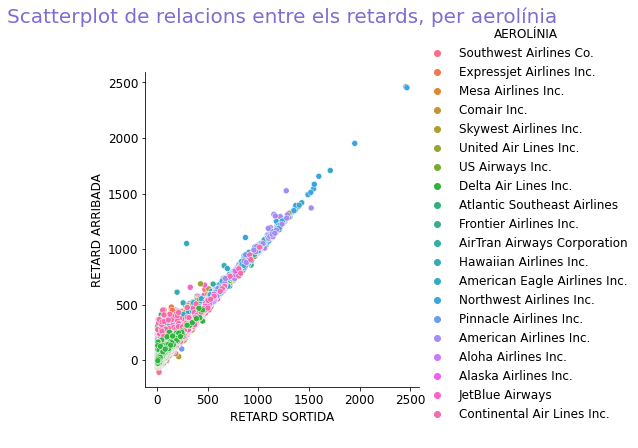

In [41]:
#podriem dibuixar l'scatterplot de retards per aerolínia, però com hi ha moltes aerolínies i vols no és una bona solució pq
#no ho visualitzem amb claredat, excepte els outliers
data = df[['AEROLÍNIA', 'RETARD SORTIDA', 'RETARD ARRIBADA']]
titol = "Scatterplot de relacions entre els retards, per aerolínia"
sns.relplot(data=data, x="RETARD SORTIDA", y="RETARD ARRIBADA", hue="AEROLÍNIA")
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8, pad=50)
plt.show()

### Visualització de més de tres variables (ArrDelay, DepDelay, AirTime i UniqueCarrier)

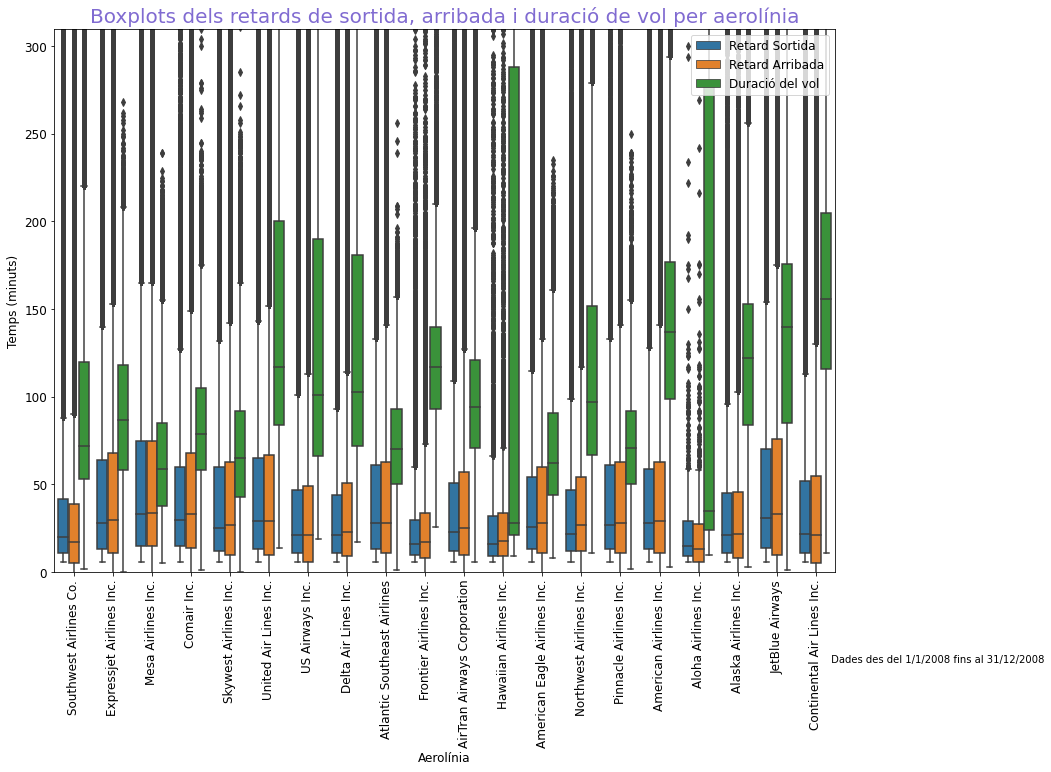

In [42]:
#com les tres variables son temporals, podriem dibuixar l'agrupació de boxplot per les tres alhora
r_sort_df = df[['AEROLÍNIA', 'RETARD SORTIDA']].copy()
r_sort_df.rename(columns={'RETARD SORTIDA': 'MINUTS'}, inplace = True)
r_sort_df['TIPUS'] = "Retard Sortida"
r_arr_df = df[['AEROLÍNIA', 'RETARD ARRIBADA']].copy()
r_arr_df.rename(columns={'RETARD ARRIBADA': 'MINUTS'}, inplace = True)
r_arr_df['TIPUS'] = "Retard Arribada"
duracio_df = df[['AEROLÍNIA', 'DURACIÓ DEL VOL']].copy()
duracio_df.rename(columns={'DURACIÓ DEL VOL': 'MINUTS'}, inplace = True)
duracio_df['TIPUS'] = "Duració del vol"

data = pd.concat([r_sort_df, r_arr_df, duracio_df])
del r_sort_df, r_arr_df, duracio_df

titol = "Boxplots dels retards de sortida, arribada i duració de vol per aerolínia"
#establim els limits de visualització
ymin, ymax = genera_rang_arrodonit(data["MINUTS"], 5, 99)

plt.figure(figsize =(14, 10))
sns.boxplot(x=data["AEROLÍNIA"], y=data["MINUTS"], hue=data["TIPUS"], )
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')
plt.xlabel("Aerolínia")
plt.ylabel("Temps (minuts)")
plt.xticks(rotation='vertical')
plt.legend(loc='upper right')
plt.ylim(ymin, ymax)

desa_figura(plt, titol)
plt.show()

In [43]:
#no se si es tractarà d'errors en les dades però de l'observació als boxplots podem observar que hi ha vols
#de duracions molt curtes, inclús de 0 minuts.. (??)
df[df['DURACIÓ DEL VOL'] < 3]

,AEROLÍNIA,RETARD ARRIBADA,RETARD SORTIDA,DURACIÓ DEL VOL,Year,Month,DayofMonth
172574,Skywest Airlines Inc.,24,26,1,2008,1,3
175925,Skywest Airlines Inc.,85,87,2,2008,1,5
175926,Skywest Airlines Inc.,61,64,2,2008,1,5
175929,Skywest Airlines Inc.,139,141,1,2008,1,5
175935,Skywest Airlines Inc.,118,98,0,2008,1,5
177448,Skywest Airlines Inc.,104,67,0,2008,1,6
182328,Skywest Airlines Inc.,112,104,2,2008,1,9
612019,Southwest Airlines Co.,16,24,2,2008,2,4
782963,Skywest Airlines Inc.,183,177,0,2008,2,12
1047958,Pinnacle Airlines Inc.,60,130,2,2008,2,3


<Figure size 1008x720 with 0 Axes>

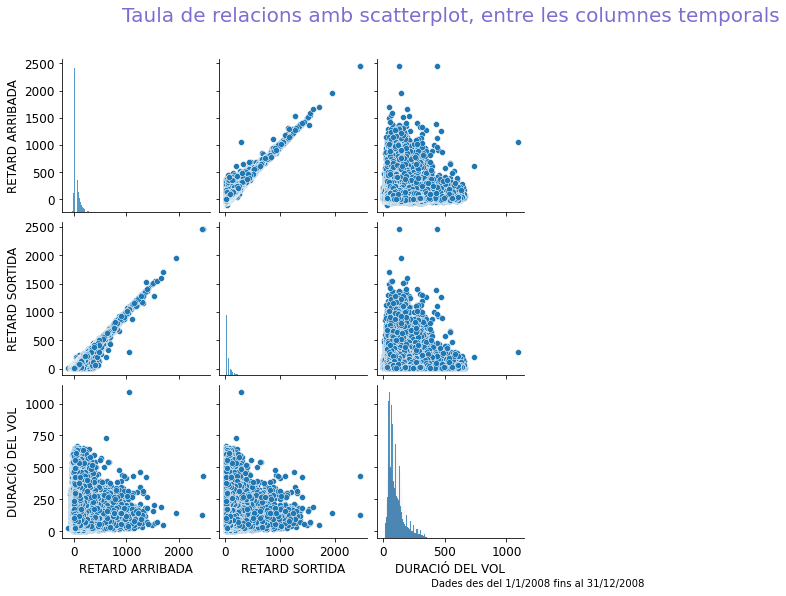

In [50]:
#podem dibuixar el pairplot entre les tres columnes temporals
#podem observar com seguim veient la relació de linealitat entre els retards de sortida i arribada,
#mentre que la duració de vol es totalment independent i sense cap relació lineal amb les altres dues columnes

data = df[["RETARD ARRIBADA", "RETARD SORTIDA", "DURACIÓ DEL VOL"]]
titol = "Taula de relacions amb scatterplot, entre les columnes temporals"
plt.figure(figsize =(14, 10))
axis = sns.pairplot(data)
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8, pad=200)
plt.figtext(1, 0, titol_info, fontsize=10, ha='center')

desa_figura(plt, titol)
plt.show()

In [62]:
#podriem visualitzar, encara que no hi ha relació lineal, les rectes de regressió dels promijos dels retards
#en funció de la duració de vol, per veure quina és la tendència 
data = df[["AEROLÍNIA", "RETARD SORTIDA", "RETARD ARRIBADA", "DURACIÓ DEL VOL"]]

data = data.groupby(["AEROLÍNIA", "DURACIÓ DEL VOL"], as_index=False).agg(
    PROMIG_RETARD_SORTIDA = ("RETARD SORTIDA", "mean"), 
    PROMIG_RETARD_ARRIBADA =  ("RETARD ARRIBADA", "mean")).round(2)
data.sample(3)

,AEROLÍNIA,DURACIÓ DEL VOL,PROMIG_RETARD_SORTIDA,PROMIG_RETARD_ARRIBADA
1149,American Airlines Inc.,298,57.62,58.01
2041,Comair Inc.,279,151.00,309.00
6735,United Air Lines Inc.,549,17.00,41.00


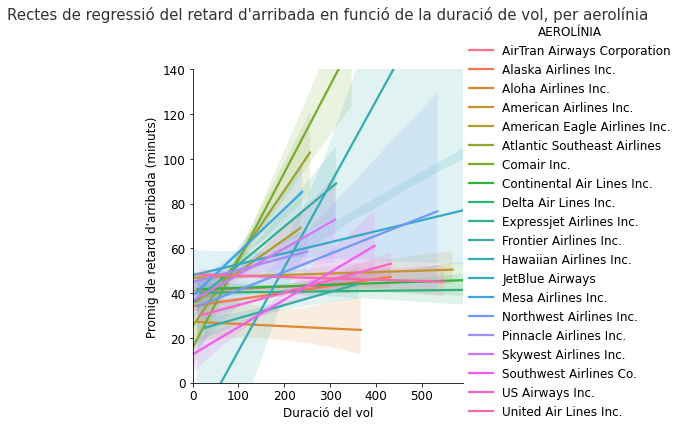

In [68]:
titol = "Rectes de regressió del retard d'arribada en funció de la duració de vol, per aerolínia"

#establim els limits de visualització
ymin, ymax = genera_rang_arrodonit(data["PROMIG_RETARD_ARRIBADA"], 3, 98)
xmin, xmax = genera_rang_arrodonit(data["DURACIÓ DEL VOL"], 0, 99)

sns.lmplot(data=data, x="DURACIÓ DEL VOL", y="PROMIG_RETARD_ARRIBADA", hue="AEROLÍNIA", scatter=False)
plt.title(titol, fontsize=15, alpha=0.8, pad=50)
plt.xlabel("Duració del vol")
plt.ylabel("Promig de retard d'arribada (minuts)")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
desa_figura(plt, titol)
plt.show()

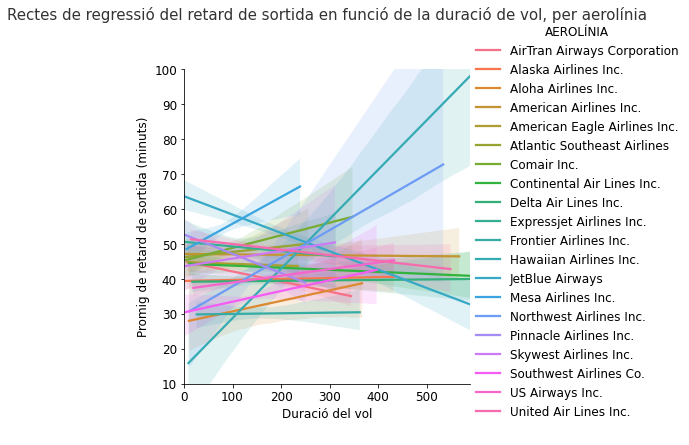

In [67]:
titol = "Rectes de regressió del retard de sortida en funció de la duració de vol, per aerolínia"

#establim els limits de visualització
ymin, ymax = genera_rang_arrodonit(data["PROMIG_RETARD_SORTIDA"], 3, 98)
xmin, xmax = genera_rang_arrodonit(data["DURACIÓ DEL VOL"], 0, 99)

sns.lmplot(data=data, x="DURACIÓ DEL VOL", y="PROMIG_RETARD_SORTIDA", hue="AEROLÍNIA", scatter=False)
plt.title(titol, fontsize=15, alpha=0.8, pad=50)
plt.xlabel("Duració del vol")
plt.ylabel("Promig de retard de sortida (minuts)")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
desa_figura(plt, titol)
plt.show()

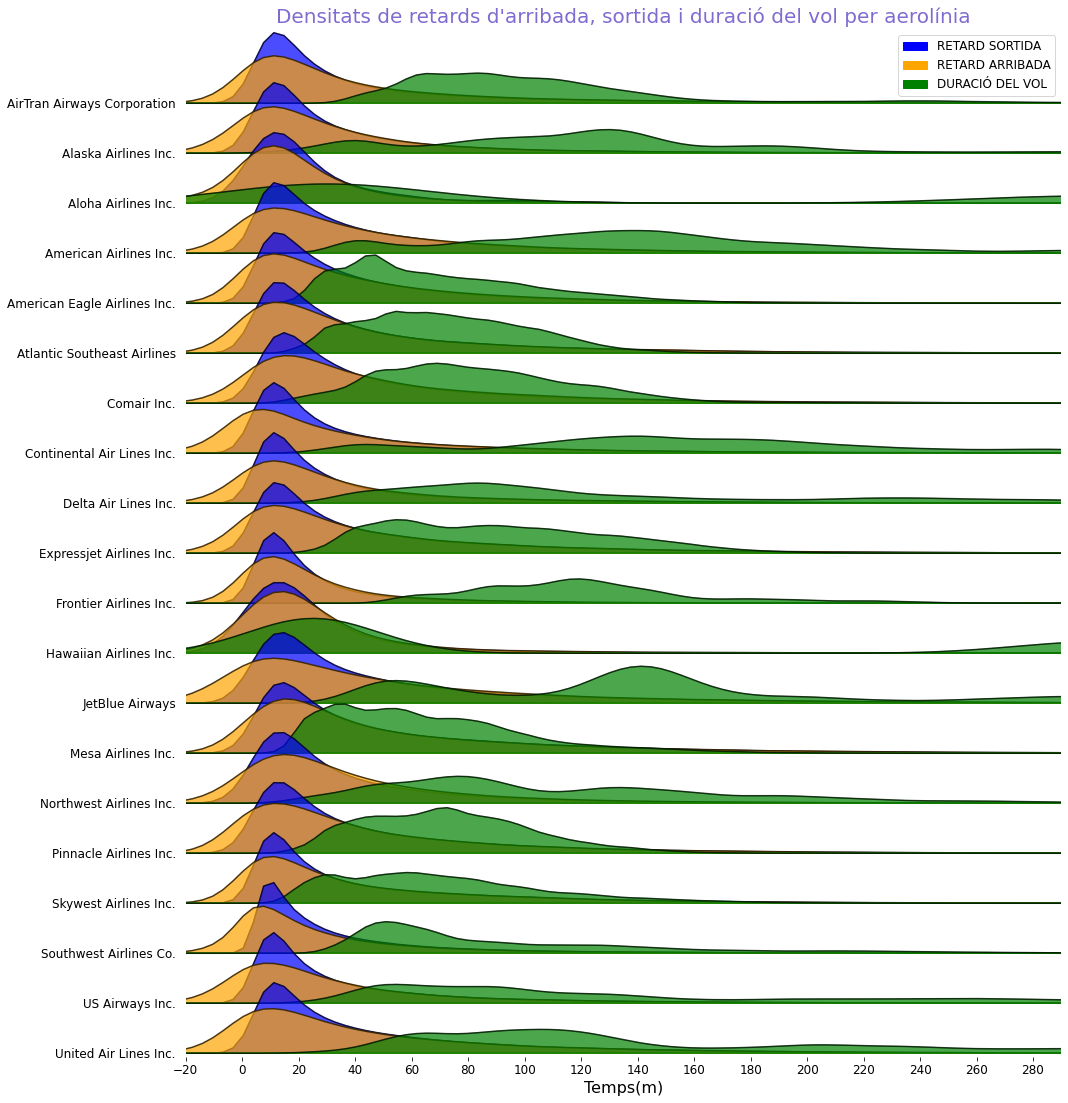

In [59]:
#podem dibuixar un ridgeline amb les corves de densitat de retards i duració del vol per cadascuna de les aerolínies
#com ens torna dades de probabilitats, veiem que aquestes s'extenen més enllà dels valors reals possibles
#(com duracions de vol negatives)
data = df[["AEROLÍNIA", "RETARD SORTIDA", "RETARD ARRIBADA", "DURACIÓ DEL VOL"]]
titol = "Densitats de retards d'arribada, sortida i duració del vol per aerolínia"

#establim el rang de visualització entre els quantils que van del 1 al 97%. 
#Agafarem els rang dels minims i màxims de cada columna
qmin, qmax = 1, 97

xmin1, xmax1 = genera_rang_arrodonit(data["RETARD SORTIDA"], qmin, qmax)
xmin2, xmax2 = genera_rang_arrodonit(data["RETARD ARRIBADA"], qmin, qmax)
xmin3, xmax3 = genera_rang_arrodonit(data["DURACIÓ DEL VOL"], qmin, qmax)
xmin, xmax = min([xmin1, xmin2, xmin3]), max([xmax1, xmax2, xmax3])

fig, axes = joypy.joyplot(data=data, column=['RETARD SORTIDA', 'RETARD ARRIBADA', 'DURACIÓ DEL VOL'], by="AEROLÍNIA", 
                          ylim='own', figsize=(15, 15), legend=True, color=['blue', 'orange', 'green'], alpha=0.7)

plt.rc("font", size=12)
plt.title(titol, fontsize=20, color='#6146C6', alpha=0.8)
plt.xlabel("Temps(m)",  fontsize=16)

#Establim els limits de visualització  i els ticks al gràfic (cada aerolínia és un axes i l'eix x n'és un altre)
for i in range(len(df["AEROLÍNIA"].unique())+1):
    axes[i].set_xlim(xmin, xmax)
axes[-1].set_xticks(range(xmin, xmax, 20))

desa_figura(plt, titol)
plt.show()

## Exercici
Exporta els gràfics com imatges o com html

In [4]:
#establim el path on desarem els gràfics per l'exercici 2 i inicialitzem un comptador per mostrar les figures ordenades
path_grafics = "grafics/fig"
num_fig = 0

#generarem una funció per desar les figures
def desa_figura(plt, titol):
    global num_fig
    num_fig += 1
    fig = path_grafics + str(num_fig) + "-" + titol.replace("/", "-")
    plt.savefig(fig, transparent=True, bbox_inches="tight", pad_inches=1)

In [ ]:
# Repassem tots els grafics d'aquest notebook afegint la funció creada, en els que ens semblen significatius, per desar-los

## Exercici 
Exporta el data set net i amb les noves columnes a Excel

In [80]:
#En la pràctica hem anat extraient les dades a tractar en petits dataframes amb els camps d'interès per cada visualització
#exportarem aquests dataframes a excel
data = df[["AEROLÍNIA", "RETARD SORTIDA", "RETARD ARRIBADA", "DURACIÓ DEL VOL"]]

#Farem varies fulles, en el mateix excel, i dividirem l'exel en fulles d'aerolínies
group = data.groupby("AEROLÍNIA")
group_l = list(group)

with pd.ExcelWriter('DelayedFlights_VisualData.xlsx') as writer:
    for i in range(0, len(group_l)):
        aerolinia = group_l[i][0]
        aerolinia_df = group_l[i][1]
        aerolinia_df.to_excel(writer, sheet_name=aerolinia, index=False)
    
    #desarem tb en una altra fulla els valors significatius, dels quantils i promig pels dos retards
    #i duració de vol, per aerolínia
    agr = {'RETARD ARRIBADA': [q25, q50, q75, "mean"], 
           'RETARD SORTIDA': [q25, q50, q75, "mean"],
           'DURACIÓ DEL VOL': [q25, q50, q75, "mean"]
          }
    data = data.groupby("AEROLÍNIA", as_index=False).agg(agr).round(2)
    data.set_index("AEROLÍNIA", inplace=True)
    data.to_excel(writer, sheet_name="quantils temporals")

## Exercici
Integra les visualitzacions gràfiques, en la tasca 5, del Sprint 3.

In [69]:
#Ajunto la tasca 5: "estructures_dataframe_amb_visualitzacions.pdf" i "Tasca 5 amb visualitzacions.ipynb"
#a la mateixa carpeta d'entrega amb les modificacions necessàries i els gràfics de les visualitzacions afegits